# Middleware
Middleware provides a way to more tightly control what happens inside the agent. Middleware is useful for the following:

- Tracking agent behavior with logging, analytics, and debugging.
- Transforming prompts, tool selection, and output formatting.
- Adding retries, fallbacks, and early termination logic.
- Applying rate limits, guardrails, and PII detection.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

### Summarization MiddleWare
Automatically summarize conversation history when approaching token limits, preserving recent messages while compressing older context. 

In [2]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage, SystemMessage

### Messagebased summarization
agent=create_agent(
    model="gpt-4o-mini",
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model="gpt-4o-mini",
            trigger=("messages",10),
            keep=("messages",4)
        )
    ]
)

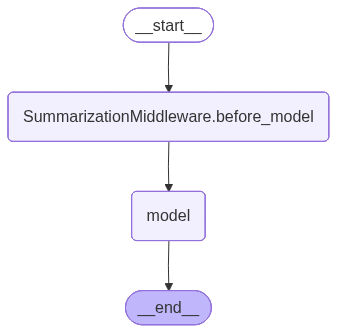

In [5]:
agent

In [3]:
config={"configurable":{"thread_id":"test-1"}}

In [4]:
questions = [
    "What is 2+2?",
    "What is 10*5?",
    "What is 100/4?",
    "What is 15-7?",
    "What is 3*3?",
    "What is 4*4?",
]

for q in questions:
    response=agent.invoke({"messages":[HumanMessage(content=q)]},config)
    print(f"Messages: {response}")
    print(f"Messages: {len(response['messages'])}")

Messages: {'messages': [HumanMessage(content='What is 2+2?', additional_kwargs={}, response_metadata={}, id='ed5ec4a2-9519-4e94-a58b-2a4f305e8777'), AIMessage(content='2 + 2 equals 4.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 14, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-D07jFHdCf4ETdfhfhhqauPhcPpN8N', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bdbe9-7559-78c3-8402-9198933afd24-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 14, 'output_tokens': 8, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': 

#### Summarization with token size

In [6]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver

# Hardcoded tool for representation
@tool
def search_hotels(city: str) -> str:
    """Search hotels - returns long response to use more tokens."""
    return f"""Hotels in {city}:
    1. Grand Hotel - 5 star, $350/night, spa, pool, gym
    2. City Inn - 4 star, $180/night, business center
    3. Budget Stay - 3 star, $75/night, free wifi"""


agent=create_agent(
    model="gpt-4o-mini",
    tools=[search_hotels],
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model="gpt-4o-mini",
            trigger=("tokens",550),
            keep=("tokens",200),
        ),
    ]
)


In [7]:
config = {"configurable": {"thread_id": "test-1"}}

In [8]:
def count_tokens(messages):
    total_chars = sum(len(str(m.content)) for m in messages)
    return total_chars // 4  # 4 chars ≈ 1 token

In [9]:
cities = ["Paris", "London", "Tokyo", "New York", "Dubai", "Singapore"]

for city in cities:
    response = agent.invoke(
        {"messages": [HumanMessage(content=f"Find hotels in {city}")]},
        config=config
    )
    
    tokens = count_tokens(response["messages"])
    print(f"{city}: ~{tokens} tokens, {len(response['messages'])} messages")
    print(f"{(response['messages'])}")

Paris: ~143 tokens, 4 messages
[HumanMessage(content='Find hotels in Paris', additional_kwargs={}, response_metadata={}, id='9ef70ab0-8382-4329-b322-ff0460d1f7f7'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 53, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-D08LAMxHFE4VuC35GI0wIgl65q1xu', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bdc0d-5612-7211-8922-068301550234-0', tool_calls=[{'name': 'search_hotels', 'args': {'city': 'Paris'}, 'id': 'call_rvv40a37sGoWmxDdCfSU2PfM', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 53

#### Summarization with fraction size

In [10]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver

@tool
def search_hotels(city: str) -> str:
    """Search hotels."""
    return f"Hotels in {city}: Grand Hotel $350, City Inn $180, Budget Stay $75"

# LOW fraction for testing!
agent = create_agent(
    model="gpt-4o-mini",
    tools=[search_hotels],
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model="gpt-4o-mini",
            trigger=("fraction", 0.005),  # 0.5% = ~640 tokens
            keep=("fraction", 0.002),     # 0.2% = ~256 tokens
        ),
    ],
)

config = {"configurable": {"thread_id": "test-1"}}

# Token counter
def count_tokens(messages):
    return sum(len(str(m.content)) for m in messages) // 4

# Test
cities = ["Paris", "London", "Tokyo", "New York", "Dubai", "Singapore"]

for city in cities:
    response = agent.invoke(
        {"messages": [HumanMessage(content=f"Hotels in {city}")]},
        config=config
    )
    tokens = count_tokens(response["messages"])
    fraction = tokens / 128000  # gpt-4o-mini context
    print(f"{city}: ~{tokens} tokens ({fraction:.4%}), {len(response['messages'])} msgs")
    print(response['messages'])

Paris: ~71 tokens (0.0555%), 4 msgs
[HumanMessage(content='Hotels in Paris', additional_kwargs={}, response_metadata={}, id='34da6ab8-b433-4f3f-9db7-1e2e5bd09e24'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 44, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3683ee3deb', 'id': 'chatcmpl-D08MZctMQnSvid4ASkC9Vv7ecPMEQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bdc0e-aab2-7b12-951b-4260df73f1e3-0', tool_calls=[{'name': 'search_hotels', 'args': {'city': 'Paris'}, 'id': 'call_1DUGWOdJLMwISTpaPIB0eZOX', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 44

### Human In the Loop MiddleWare
Pause agent execution for human approval, editing, or rejection of tool calls before they execute.

In [11]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver

def read_email_tool(email_id: str) -> str:
    """Mock function to read an email by its ID."""
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient: str, subject: str, body: str) -> str:
    """Mock function to send an email."""
    return f"Email sent to {recipient} with subject '{subject}'"

In [12]:
agent=create_agent(
    model="gpt-4o",
    tools=[read_email_tool,send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool":{
                    "allowed_decisions":["approve","edit","reject"]
                },
                "read_email_tool":False,

            }
        )
    ]
)

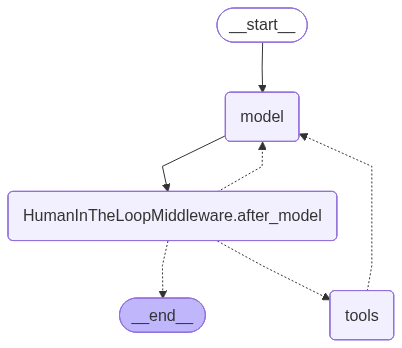

In [13]:
agent

#### Mail Acceptance

In [14]:
config = {"configurable": {"thread_id": "test-approve"}}
# Step 1: Request
result = agent.invoke(
    {"messages": [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'")]},
    config=config
)

In [15]:
result

{'messages': [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'", additional_kwargs={}, response_metadata={}, id='50bc1534-0b63-47f5-a4d8-21d1224abcf8'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 97, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'id': 'chatcmpl-D08NmzJfEbgx3MhepEEY1WoDHeTsA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bdc0f-d19a-7fb1-b763-a2c9fe00fbdc-0', tool_calls=[{'name': 'send_email_tool', 'args': {'recipient': 'john@test.com', 'subject': 'Hello', 'body': 'How are you?'}, 'id': 'call_o9nV50SWgkCBIgQB

In [16]:
from langgraph.types import Command
# Step 2: Approve
if "__interrupt__" in result:
    print("Paused! Approving...")
    
    result = agent.invoke(
        Command(
            resume={
                "decisions": [
                    {"type": "approve"}
                ]
            }
        ),
        config=config
    )
    
    print(f"Result: {result['messages'][-1].content}")

Paused! Approving...
Result: The email has been sent to john@test.com with the subject "Hello".


In [17]:
result

{'messages': [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'", additional_kwargs={}, response_metadata={}, id='50bc1534-0b63-47f5-a4d8-21d1224abcf8'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 97, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'id': 'chatcmpl-D08NmzJfEbgx3MhepEEY1WoDHeTsA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bdc0f-d19a-7fb1-b763-a2c9fe00fbdc-0', tool_calls=[{'name': 'send_email_tool', 'args': {'recipient': 'john@test.com', 'subject': 'Hello', 'body': 'How are you?'}, 'id': 'call_o9nV50SWgkCBIgQB

#### Mail Rejection

In [18]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver


def read_email_tool(email_id: str) -> str:
    """Mock function to read an email by its ID."""
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient: str, subject: str, body: str) -> str:
    """Mock function to send an email."""
    return f"Email sent to {recipient} with subject '{subject}'"

agent = create_agent(
    model="gpt-4o",
    tools=[read_email_tool,send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool": {
                    "allowed_decisions": ["approve", "edit", "reject"],
                },
                "read_email_tool": False,
            }
        ),
    ],
)

In [19]:
config = {"configurable": {"thread_id": "test-reject"}}
# Step 1: Request
result = agent.invoke(
    {"messages": [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'")]},
    config=config)

In [20]:
# Step 2: Reject
if "__interrupt__" in result:
    print("Paused! Approving...")
    
    result = agent.invoke(
        Command(
            resume={
                "decisions": [
                    {"type": "reject"}
                ]
            }
        ),
        config=config
    )
    
    print(f"Result: {result['messages'][-1].content}")

Paused! Approving...
Result: It seems there was an issue with sending the email. Could you please provide more information or try again?


In [21]:
result

{'messages': [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'", additional_kwargs={}, response_metadata={}, id='a79db783-17fc-4fd8-932e-42721a63cf18'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 97, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'id': 'chatcmpl-D08PFODxTpHCtpesaOl4FmhKowhez', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bdc11-3485-7681-aa60-a876cc379671-0', tool_calls=[{'name': 'send_email_tool', 'args': {'recipient': 'john@test.com', 'subject': 'Hello', 'body': 'How are you?'}, 'id': 'call_3b7nJX6lE8rwNj0X

#### Mail Editing

In [22]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver


def read_email_tool(email_id: str) -> str:
    """Mock function to read an email by its ID."""
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient: str, subject: str, body: str) -> str:
    """Mock function to send an email."""
    return f"Email sent to {recipient} with subject '{subject}'"

agent = create_agent(
    model="gpt-4o",
    tools=[read_email_tool,send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool": {
                    "allowed_decisions": ["approve", "edit", "reject"],
                },
                "read_email_tool": False,
            }
        ),
    ],
)

In [23]:
config = {"configurable": {"thread_id": "test-edit"}}

# Step 1: Request (with wrong info)
result = agent.invoke(
    {"messages": [HumanMessage(content="Send email to wrong@email.com with subject 'Test' and body 'Hello'")]},
    config=config
)

In [24]:
result

{'messages': [HumanMessage(content="Send email to wrong@email.com with subject 'Test' and body 'Hello'", additional_kwargs={}, response_metadata={}, id='357e9702-4163-44ff-ae8b-3fcf76fb8949'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 95, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'id': 'chatcmpl-D08QPUo8e4WLO6BDnMwYd1680IxKL', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bdc12-4d84-76f1-a33f-076c36e44153-0', tool_calls=[{'name': 'send_email_tool', 'args': {'recipient': 'wrong@email.com', 'subject': 'Test', 'body': 'Hello'}, 'id': 'call_30epPcYs1zfDKnLtaFPMRfXa', '

In [25]:
# Step 2: Edit and approve
if "__interrupt__" in result:
    print("Paused! Editing...")
    
    result = agent.invoke(
        Command(
            resume={
                "decisions": [
                    {
                        "type": "edit",
                        "edited_action": {
                            "name": "send_email_tool",      # Tool name
                            "args": {                   # New arguments
                                "recipient": "correct@email.com",
                                "subject": "Corrected Subject",
                                "body": "This was edited by human before sending"
                            }
                        }
                    }
                ]
            }
        ),
        config=config
    )
    
    print(f"Result: {result['messages'][-1].content}")

Paused! Editing...
Result: I attempted to send the email, but it looks like the address you provided is "wrong@email.com". It's too generic and possibly incorrect. Please double-check the recipient's email address to ensure accuracy. If you confirm that it's correct, please let me know, and I'll resend it.


In [26]:
result

{'messages': [HumanMessage(content="Send email to wrong@email.com with subject 'Test' and body 'Hello'", additional_kwargs={}, response_metadata={}, id='357e9702-4163-44ff-ae8b-3fcf76fb8949'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 95, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'id': 'chatcmpl-D08QPUo8e4WLO6BDnMwYd1680IxKL', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bdc12-4d84-76f1-a33f-076c36e44153-0', tool_calls=[{'type': 'tool_call', 'name': 'send_email_tool', 'args': {'recipient': 'correct@email.com', 'subject': 'Corrected Subject', 'body': 'This was edit